## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
#%%bash
#ls

In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj, dataset_in_memory, check_datasets
from LOW_LEVEL_UTILITIES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_decay_p_factor
from simulation_dictionary import SimulationDictionary 
from VAE.vae_model import Compositional_VAE

import numpy as np
import torch
import pyro
from pyro.infer import SVI, TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 
from pyro.optim import Adam, Adamax, SGD, RMSprop

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Get the data

In [4]:
#disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
#real_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/DAPI_ONLY_v3/"
#mMNIST_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/MULTI_MNIST/"   
real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"
#mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"
#mMNIST_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_MNIST/"
#fashion_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_FashionMNIST/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v4/"
#real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"

train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_train_large_hard",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_test_large_hard",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_with_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_with_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=torch.cuda.is_available())

Dataset lenght: 1688
imgs.shape torch.Size([8, 1, 128, 128])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


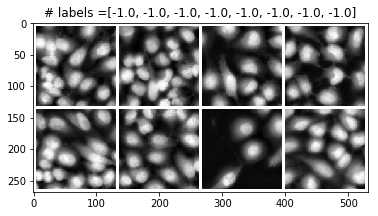

In [5]:
check_datasets(train_dataset)

Dataset lenght: 296
imgs.shape torch.Size([8, 1, 128, 128])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


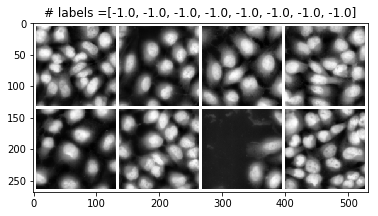

In [6]:
check_datasets(test_dataset)

tensor(-1., device='cuda:0')


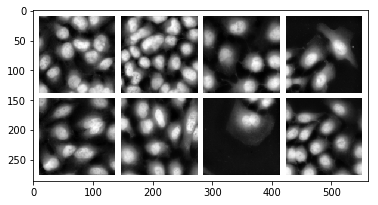

In [7]:
imgs_in, labels = train_dataset.load(8)
print(labels[0])
show_batch(imgs_in)

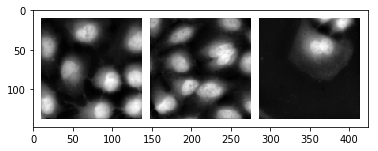

In [8]:
show_batch(imgs_in[2:-1:2])

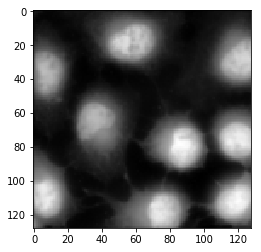

In [9]:
show_batch(imgs_in[2:3])

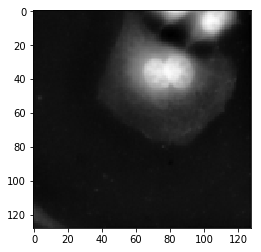

In [10]:
show_batch(imgs_in[-2:-1])

Text(0.5, 0, 'pixel intensity')

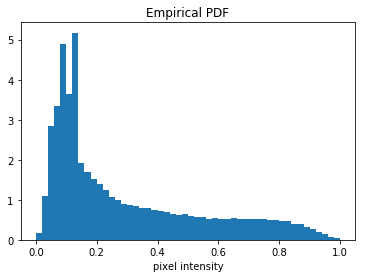

In [11]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=50, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

Text(0.5, 0, 'Average intensity in box of size 15')

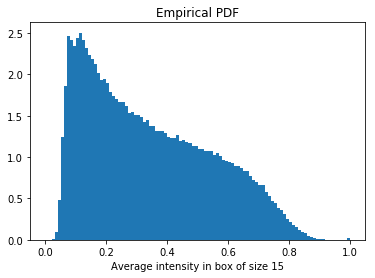

In [12]:
size=15
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

Text(0.5, 0, 'Average intensity in box of size 35')

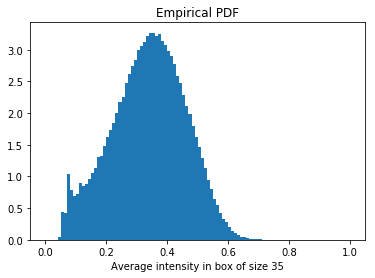

In [13]:
size=35
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

# Generate the names

In [76]:
write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/buckets/VAE-ARCHIVE/'
#write_dir  = '/Users/ldalessi/DAPI_unsupervised/ARCHIVE/'


descriptor        = "DAPI_branch11_v07"
#descriptor        = "MNIST_v001"
#descriptor        = "FASHION_unit_cauchy_t4_v3"
#descriptor        = "MNIST_unit_cauchy_t4_v4"
#descriptor        = "DISK_v4"
#descriptor        = "DISK_speed"
name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
epoch_restart     = 100
is_restart = True
is_pretrained = False

if(is_restart):

    hyper_params = load_obj(write_dir,name_hyper_params+"_"+str(epoch_restart))
    hyper_params.check_consistency()
    print(hyper_params)
    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    min_loss = min(history_dict["test_loss"])
    vae = Compositional_VAE.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))

else:    
    
    epoch_restart     = -1
    hyper_params=SimulationDictionary()
    hyper_params.check_consistency()
    print(hyper_params)
    
    min_loss = 99999999
    history_dict = {
        "train_loss" : [],
        "test_loss" : [],
        
        "fg_mu" : [],
        "bg_mu" : [],
        "fg_sigma" : [],
        "bg_sigma" : [],
        }
    
    vae = Compositional_VAE(hyper_params)
    vae.reset()
    if(is_pretrained):
        vae.load_everything("/home/jupyter/REPOS/spacetx-research/ARCHIVE/GREAT_RESULT/","DAPI")
    
save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")

{'NMS.overlap_threshold': 0.2, 'REGULARIZATION.lambda_small_box_size': 0.0, 'NMS.p_threshold': 0.0, 'REGULARIZATION.lambda_mask_volume_fraction': 1.0, 'REGULARIZATION.lambda_mask_volume_absolute': 0.0, 'use_cuda': True, 'SD.dim_h2': -1, 'SD.dim_h1': -1, 'REGULARIZATION.volume_mask_max': 500.0, 'UNET.CH_after_first_two_conv': 32, 'SD.width': 28, 'REGULARIZATION.volume_mask_min': 0.0, 'PRIOR.size_object_expected': 20, 'UNET.N_prediction_maps': 1, 'IMG.size_raw_image': 80, 'UNET.N_up_conv': 2, 'PRIOR.width_zwhat': 0.001, 'ZWHAT.dim': 50, 'REGULARIZATION.lambda_overlap': 0.0, 'REGULARIZATION.randomize_nms_factor': 0.2, 'PRIOR.n_objects_expected': 10, 'PRIOR.width_zmask': 0.001, 'REGULARIZATION.p_corr_factor': 0.0, 'UNET.N_max_pool': 4, 'REGULARIZATION.volume_mask_expected': 300.0, 'ZMASK.dim': 50, 'PRIOR.size_object_max': 40, 'IMG.ch_in_description': ['DAPI'], 'PRIOR.n_objects_max': 30, 'PRIOR.size_object_min': 10, 'REGULARIZATION.LOSS_ZWHAT': 10.0}


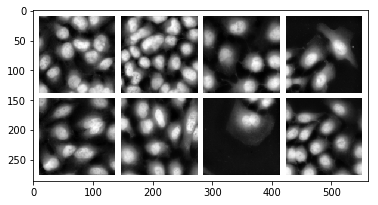

In [15]:
show_batch(imgs_in)

At layer l=  0  we have w_h_j_rf_wloc_hloc=  0 (128, 128, 1, 1, 0.5, 0.5)
At layer l=  1  we have w_h_j_rf_wloc_hloc=  1 (128, 128, 1.0, 5, 0.5, 0.5)
At layer l=  2  we have w_h_j_rf_wloc_hloc=  2 (64, 64, 2.0, 6, 1.0, 1.0)
At layer l=  3  we have w_h_j_rf_wloc_hloc=  3 (64, 64, 2.0, 14, 1.0, 1.0)
At layer l=  4  we have w_h_j_rf_wloc_hloc=  4 (32, 32, 4.0, 16, 2.0, 2.0)
At layer l=  5  we have w_h_j_rf_wloc_hloc=  5 (32, 32, 4.0, 32, 2.0, 2.0)
At layer l=  6  we have w_h_j_rf_wloc_hloc=  6 (16, 16, 8.0, 36, 4.0, 4.0)
At layer l=  7  we have w_h_j_rf_wloc_hloc=  7 (16, 16, 8.0, 68, 4.0, 4.0)
At layer l=  8  we have w_h_j_rf_wloc_hloc=  8 (8, 8, 16.0, 76, 8.0, 8.0)
At layer l=  9  we have w_h_j_rf_wloc_hloc=  9 (8, 8, 16.0, 140, 8.0, 8.0)
At layer l=  10  we have w_h_j_rf_wloc_hloc=  10 (16, 16, 8.0, 156, 4.0, 4.0)
At layer l=  11  we have w_h_j_rf_wloc_hloc=  11 (16, 16, 8.0, 188, 4.0, 4.0)
At layer l=  12  we have w_h_j_rf_wloc_hloc=  12 (32, 32, 4.0, 196, 2.0, 2.0)
At layer l=  13  w

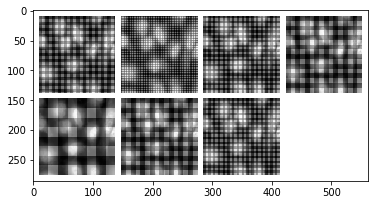

In [16]:
vae.inference.unet.describe_receptive_field(imgs_in)
img_with_grid = vae.inference.unet.show_grid(imgs_in)
print(img_with_grid.shape)
show_batch(img_with_grid[5])

### Debug model and guide

In [17]:
#print("TEST SAMPLE")
#test_model(vae.model, 
#           vae.guide, TraceGraph_ELBO())
#
#print("TEST PARALLEL ENUM")
#test_model(vae.model, 
#           config_enumerate(vae.guide, "parallel"), 
#           TraceEnum_ELBO(max_plate_nesting=2))

## Global parameters

In [18]:
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# batch size
batch_size = 50
time_scale_decay_prob = 40

# setup the optimizer
optimizer = Adam({"lr": 1.0e-3, "betas":(0.9, 0.999)})
#optimizer = RMSprop({"lr": 1.0e-4})

svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))

# Actual train loop

In [19]:
# training loop
#epoch_restart = 45
#for delta_epoch in range(1,-1):

for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
   
    
    vae.inference.nms.overlap_threshold=0.2
    vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
    vae.randomize_nms_factor = 0.1
    vae.n_objects_max=30
    vae.train()   
    
    
    print("epoch,vae.p_corr_factor,vae.randomize_nms_factor",epoch,vae.p_corr_factor,vae.randomize_nms_factor)
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(delta_epoch==1))
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
                
    history_dict["train_loss"].append(loss)
    try:
        history_dict["fg_mu"].append(pyro.param("fg_mu").item())
        history_dict["bg_mu"].append(pyro.param("bg_mu").item())
        history_dict["fg_sigma"].append(pyro.param("fg_sigma").item())
        history_dict["bg_sigma"].append(pyro.param("bg_sigma").item())
        
    except:
        pass
            
    if(epoch % TEST_FREQUENCY == 0):      
        vae.inference.nms.overlap_threshold=0.2
        vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
        vae.randomize_nms_factor = 0.1
        vae.n_objects_max=30
        vae.eval()
            
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(delta_epoch==1))        
        history_dict["test_loss"].append(loss)
            
        if(loss < min_loss):
            min_loss = loss
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_obj(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))

epoch,vae.p_corr_factor,vae.randomize_nms_factor 0 0.5 0.1
i=   0 train_loss=11494031360.00000
i=   1 train_loss=9519968256.00000
i=   2 train_loss=5903734784.00000
i=   3 train_loss=2681218048.00000
i=   4 train_loss=874957440.00000
i=   5 train_loss=1254316928.00000
i=   6 train_loss=1481975680.00000
i=   7 train_loss=928503680.00000
i=   8 train_loss=1022293440.00000
i=   9 train_loss=629978688.00000
i=  10 train_loss=497850784.00000
i=  11 train_loss=531338976.00000
i=  12 train_loss=382511200.00000
i=  13 train_loss=285961024.00000
i=  14 train_loss=243661120.00000
i=  15 train_loss=194236864.00000
i=  16 train_loss=166711920.00000
i=  17 train_loss=149334224.00000
i=  18 train_loss=134937200.00000
i=  19 train_loss=114107664.00000
i=  20 train_loss=99183376.00000
i=  21 train_loss=86406552.00000
i=  22 train_loss=74393920.00000
i=  23 train_loss=72056640.00000
i=  24 train_loss=70356976.00000
i=  25 train_loss=70228368.00000
i=  26 train_loss=69003392.00000
i=  27 train_loss=6803

# Check the results

In [43]:
print(history_dict["train_loss"][-5:])
print(history_dict["test_loss"][-5:])

print(history_dict["fg_mu"][-5:])
print(history_dict["bg_mu"][-5:])

print(history_dict["fg_sigma"][-5:])
print(history_dict["bg_sigma"][-5:])

[-96018.69757575757, -78520.35761363637, -100659.69227272728, -91674.62121212122, -90077.00196969697]
[-63436.512, -96111.818, -96510.316, -101574.894, -97763.19]
[0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421]
[0.09994281828403473, 0.10019563138484955, 0.10064706951379776, 0.10023483633995056, 0.10050622373819351]
[0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224]
[0.11681606620550156, 0.11547541618347168, 0.11440662294626236, 0.11313807219266891, 0.11208133399486542]


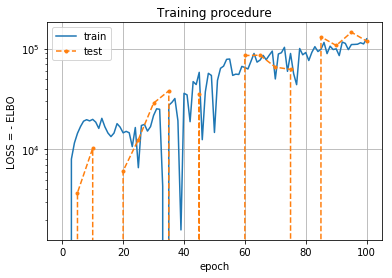

In [77]:
plt.yscale('log')
y_shift=0
x_shift=0
sign =-1.0
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"]), TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
#plt.ylim(bottom=-250000, top=200000)
#plt.ylim(bottom=-250000, top=0)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

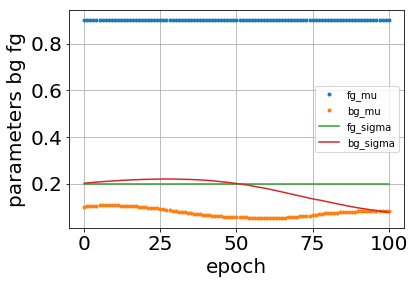

In [78]:
# Create a plot with learned parameters
fontsize=20
labelsize=20
plt.xlabel('epoch',fontsize=fontsize)
plt.ylabel('parameters bg fg',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.plot(history_dict["fg_mu"],'.')
plt.plot(history_dict["bg_mu"],'.')

plt.plot(history_dict["fg_sigma"],'-')
plt.plot(history_dict["bg_sigma"],'-')

plt.legend(['fg_mu','bg_mu',
            'fg_sigma','bg_sigma'])
plt.grid(True)
              
mp.savefig(write_dir+name_vae+'_hystory.png')

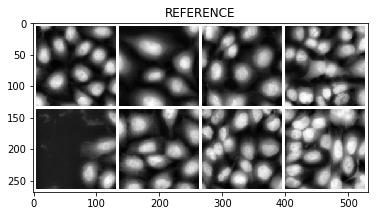

In [79]:
from matplotlib import pyplot as mp

#reference_dir = '/Users/ldalessi/DAPI_unsupervised/REFERENCES/'
#reference_dir = '/home/ldalessi/DATA/REFERENCE/'
reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
#name='reference_mMNIST_v2'
#name='reference_disks_v3'
name='reference_dapi'
#name='reference_dapi_small'
#name='reference_fashion'

# create image if necessary
#reference_imgs, labels=test_dataset.load(8)
#save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

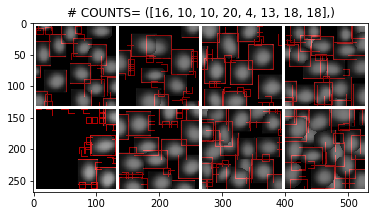

In [80]:
vae.inference.nms.overlap_threshold=0.4
vae.p_corr_factor = 0.0
vae.randomize_nms_factor = 0.0
vae.n_objects_max=30
        
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'_rec_both.png')

In [81]:
chosen=7
print(z_where.prob[chosen].view(-1))

tensor([0.9965, 0.9948, 0.9944, 0.9932, 0.9923, 0.9909, 0.9898, 0.9894, 0.9882,
        0.9784, 0.9775, 0.9769, 0.9712, 0.9649, 0.9637, 0.9596, 0.9247, 0.7010,
        0.4595, 0.4503, 0.4283, 0.3366, 0.2495, 0.0859, 0.0523, 0.0456, 0.0408,
        0.0272, 0.0253, 0.0171], device='cuda:0')


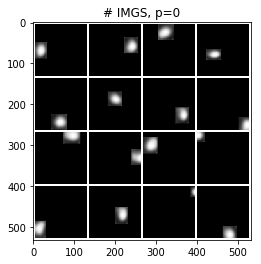

In [82]:
prob_tmp = np.round(z_where.prob[chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
prob_title = 0
b=show_batch(putative_imgs[chosen,:16],nrow=4,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'_rec_imgs.png')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


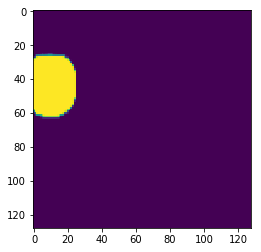

In [83]:
plt.imshow(putative_masks[0,0,0].cpu())
print(putative_masks[0,0,0,10])

DAPI_branch11_v07_vae


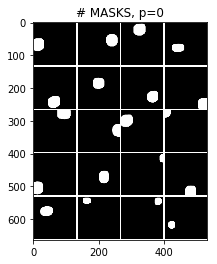

In [84]:
b=show_batch(putative_masks[chosen,:20],nrow=4,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'_rec_masks.png')

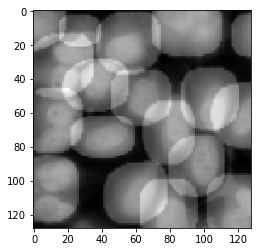

In [85]:
active = (z_where.prob[chosen] > 0.5)[...,None,None].float()
show_batch(torch.sum(active*putative_masks[chosen],dim=0,keepdim=True)+2*reference_imgs[chosen])
mp.savefig(write_dir+name_vae+'_debug0_imgs.png')

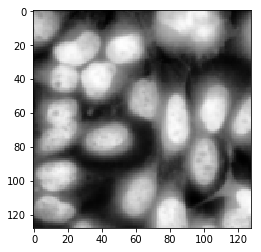

In [65]:
show_batch(reference_imgs[chosen:chosen+1])

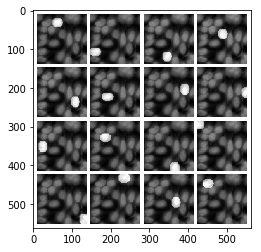

In [66]:
show_batch(putative_masks[chosen,:16]+reference_imgs[chosen,0])
mp.savefig(write_dir+name_vae+'_debug1_imgs.png')

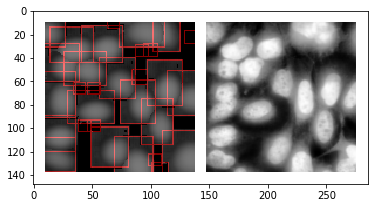

In [67]:
tmp1 = rec_img[chosen].unsqueeze(0)
tmp2 = reference_imgs[chosen].unsqueeze(0).expand(-1,3,-1,-1)
tmp = torch.cat((tmp1,tmp2),dim=0)
show_batch(tmp)
mp.savefig(write_dir+name_vae+'_debug2_imgs.png')

In [57]:
print("reg_small_box ----->",vae.lambda_small_box_size*reg.small_box_size[chosen,:16].detach().cpu())
print("reg_mask_fraction ->",vae.lambda_mask_volume_fraction*reg.mask_volume_fraction[chosen,:16].detach().cpu())
print("reg_mask_absolute ->",vae.lambda_mask_volume_absolute*reg.mask_volume_absolute[chosen,:16].detach().cpu())
print("reg_mask_overlap -->",vae.lambda_overlap*reg.overlap_mask[chosen,:16].detach().cpu())
print("mask_volumes ------>",torch.sum(putative_masks[chosen,:16],dim=(-2,-1)).view(-1))
print("probability object >",z_where.prob[chosen,:16].detach().cpu().view(-1))

reg_small_box -----> tensor([1.2120, 1.1329, 1.1448, 1.1778, 1.1276, 1.1387, 1.1462, 5.5269, 1.1411,
        1.1514, 1.9449, 1.6994, 7.0766, 6.2242, 2.9454, 0.0203])
reg_mask_fraction -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_absolute -> tensor([1.1780e-03, 7.0741e+00, 3.1782e+01, 3.8087e+01, 4.1627e+01, 2.6342e+01,
        8.4752e+00, 0.0000e+00, 1.0111e-01, 4.7466e+00, 0.0000e+00, 1.2165e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])
reg_mask_overlap --> tensor([1.3518, 1.3519, 1.3519, 1.3498, 1.3513, 1.3480, 1.3471, 1.3523, 1.3519,
        1.3515, 1.3508, 1.3529, 1.3530, 1.3766, 1.4095, 1.4366])
mask_volumes ------> tensor([500.2059, 515.9583, 533.8254, 537.0286, 538.7116, 530.7949, 517.4673,
        390.6304, 501.9079, 513.0721, 497.8901, 520.9274, 227.3499, 135.5479,
         94.9156,  54.3081], device='cuda:0')
probability object > tensor([0.9944, 0.9933, 0.9929, 0.9922, 0.9914, 0.9892, 0.9891, 0.9891, 0.9881,
        0.98

In [58]:
print("logp_off -------->",logp.box_off[chosen,:16].detach().cpu())
print("logp_on  -------->",logp.box_on[chosen,:16].detach().cpu())
print("probability object",z_where.prob[chosen,:16].detach().cpu().view(-1))

logp_off --------> tensor([3462.9011, -179.3784,  -53.3274, -470.3529, -483.0404, -367.3214,
        -412.3667, -258.2451, -259.5566, -154.8817, -364.8868, -287.1517,
         -25.4274,   23.6190,  -88.3409,   98.3772])
logp_on  --------> tensor([4611.1777, 1046.5170, 1319.6808,  815.6788,  999.2313,  958.1306,
         915.8896,  690.9448,  958.5941,  933.6814,  853.5674,  987.3254,
         497.2409,  306.5675,  155.0218, -168.3840])
probability object tensor([0.9944, 0.9933, 0.9929, 0.9922, 0.9914, 0.9892, 0.9891, 0.9891, 0.9881,
        0.9870, 0.9859, 0.9837, 0.9820, 0.7459, 0.4169, 0.0793])


Text(0.5, 0, 'Log prob')

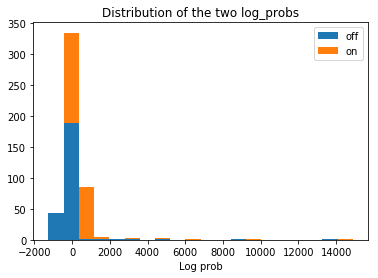

In [59]:
off = logp.box_off.view(-1).detach().cpu().numpy()
on  = logp.box_on.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on],bins=20,histtype="bar",stacked=True)
plt.legend(["off","on"], loc='upper right')
plt.title("Distribution of the two log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

_0000 0.5
_0005 0.4375
_0010 0.375
_0015 0.3125
_0020 0.25
_0025 0.1875
_0030 0.125
_0035 0.0625
_0040 0.0
_0045 0.0
_0050 0.0
_0055 0.0
_0060 0.0
_0065 0.0
_0070 0.0
_0075 0.0
_0080 0.0
_0085 0.0
_0090 0.0
_0095 0.0
_0100 0.0
['DAPI_branch11_v08_vae_0000.png', 'DAPI_branch11_v08_vae_0005.png', 'DAPI_branch11_v08_vae_0010.png', 'DAPI_branch11_v08_vae_0015.png', 'DAPI_branch11_v08_vae_0020.png', 'DAPI_branch11_v08_vae_0025.png', 'DAPI_branch11_v08_vae_0030.png', 'DAPI_branch11_v08_vae_0035.png', 'DAPI_branch11_v08_vae_0040.png', 'DAPI_branch11_v08_vae_0045.png', 'DAPI_branch11_v08_vae_0050.png', 'DAPI_branch11_v08_vae_0055.png', 'DAPI_branch11_v08_vae_0060.png', 'DAPI_branch11_v08_vae_0065.png', 'DAPI_branch11_v08_vae_0070.png', 'DAPI_branch11_v08_vae_0075.png', 'DAPI_branch11_v08_vae_0080.png', 'DAPI_branch11_v08_vae_0085.png', 'DAPI_branch11_v08_vae_0090.png', 'DAPI_branch11_v08_vae_0095.png', 'DAPI_branch11_v08_vae_0100.png']


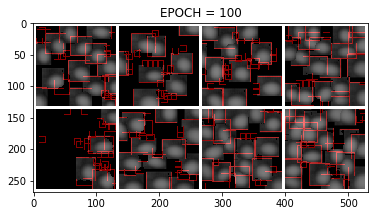

In [68]:
list_of_movie_files = []
for epoch in range(0,125,5):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    

    try:
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
        print(label,vae.p_corr_factor)
        rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
        counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        b=show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
        name_output = name_vae+label+'.png'
        list_of_movie_files.append(name_output)
        mp.savefig(write_dir+name_output) 
    except:
        pass
    
print(list_of_movie_files)

In [69]:
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)


## Check individual images

In [70]:
#from ipywidgets import interactive, IntSlider
#from PIL import Image
from IPython.display import Image

def show_frame(n):
    return Image(filename=write_dir+list_of_movie_files[n])  
    #image = Image.open(write_dir+list_of_movie_files[n], mode='r')
    #plt.imshow(image)
    #plt.show()    

# Widget does not work
#interactive_plot = interactive(show_frame,n=IntSlider(min=0, max=N_frames-1, step=1))
#output = interactive_plot.children[-1]
#interactive_plot

In [71]:
#write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#name_vae = "MNIST_unit_cauchy_t4_v2_vae_0"
#list_of_movie_files = []
#for file in os.listdir(write_dir):
#    if file.startswith(name_vae) and file.endswith(".png"):
#        list_of_movie_files.append(file)
N_frames = len(list_of_movie_files)
print(list_of_movie_files)
print(N_frames)

['DAPI_branch11_v08_vae_0000.png', 'DAPI_branch11_v08_vae_0005.png', 'DAPI_branch11_v08_vae_0010.png', 'DAPI_branch11_v08_vae_0015.png', 'DAPI_branch11_v08_vae_0020.png', 'DAPI_branch11_v08_vae_0025.png', 'DAPI_branch11_v08_vae_0030.png', 'DAPI_branch11_v08_vae_0035.png', 'DAPI_branch11_v08_vae_0040.png', 'DAPI_branch11_v08_vae_0045.png', 'DAPI_branch11_v08_vae_0050.png', 'DAPI_branch11_v08_vae_0055.png', 'DAPI_branch11_v08_vae_0060.png', 'DAPI_branch11_v08_vae_0065.png', 'DAPI_branch11_v08_vae_0070.png', 'DAPI_branch11_v08_vae_0075.png', 'DAPI_branch11_v08_vae_0080.png', 'DAPI_branch11_v08_vae_0085.png', 'DAPI_branch11_v08_vae_0090.png', 'DAPI_branch11_v08_vae_0095.png', 'DAPI_branch11_v08_vae_0100.png']
21


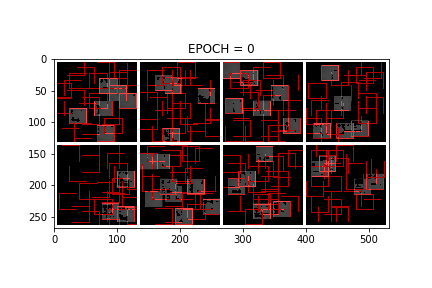

In [72]:
show_frame(0)

In [ ]:
show_frame(9)

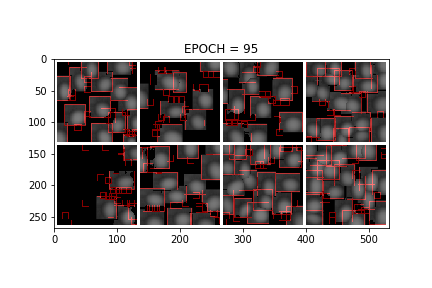

In [75]:
show_frame(19)

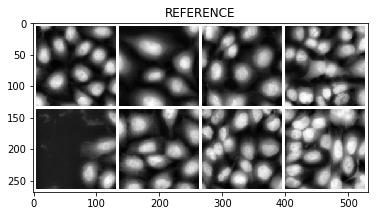

In [74]:
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")